# **Diversion Data Exploratory Analysis**

Author: Bridget Bittmann

Date Created: 09/14/2021

Date Modified: 01/14/2022

In [ ]:
#Import necessary packages

import pandas as pd #to work with data arrays
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs 
from matplotlib.dates import DateFormatter #to help with timeseries
import glob #to batch import csv files
from sklearn import metrics #to find r2 values from regression
!pip install pymannkendall
import pymannkendall as mk #used to perform mann-kendall stationarity test
from sklearn.cluster import KMeans #to cluster using kmeans
import os #for file output paths
import matplotlib.patches as mpatches
import matplotlib.lines as Line2D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Navigate to workspace

%cd /content/drive/MyDrive/spatial_colab/
%ls

/content/drive/MyDrive/spatial_colab
datasets/  pod_pou_lulcc/


In [ ]:
## IMPORT ALL DIVERSION FILES ##

all_files =[]
csv = glob.glob('datasets/diversion_timeseries/WRA_20220712_db206/*_history.csv')
common_name_flow = pd.read_csv('datasets/diversion_timeseries/relates/name_dictionary_flow.csv')
names = list(common_name_flow['DiversionName'])
div_dict = dict(zip(common_name_flow['HydrologyID'], common_name_flow['DiversionName']))

for f in csv:
  df = pd.read_csv(f, parse_dates=['HSTDate'], index_col=False)
  all_files.append(df)

full = pd.concat(all_files)
full['Name'] = full['SiteID'].map(div_dict)
full = full.drop(['SiteType', 'Gage Height (Feet)', 'Irrigation Year', 'Unnamed: 6', 'Unnamed: 5'], 
                 axis=1).rename({'Flow (CFS)': 'Diversion (cfs)',
                                 'HSTDate': 'DataDate'}, axis=1).sort_values(by='Name').dropna()
full['Acre_feet'] = full['Diversion (cfs)']*86400/43559.9

In [ ]:
## IMPORT ALL ACCOUNTING FILES ##

account = []
csv = glob.glob('datasets/diversion_timeseries/WRA_20220920_c996a/*_accounting.csv')
div_dict = dict(zip(common_name_flow['HydrologyID'], common_name_flow['NewName']))

for f in csv: 
  df = pd.read_csv(f, parse_dates=['Accounting Date'], index_col = False)
  account.append(df)

account_full = pd.concat(account)
account_full['Name'] = account_full['SiteID'].map(div_dict)

In [7]:
## ACCOUNTING VALUES WANTED AT END OF YEAR ##

account_full['Day'] = account_full['Accounting Date'].dt.strftime('%m/%d')
end_account = account_full[account_full['Day'] == '10/31']
end_account = end_account.drop(['SiteID', 'SiteType', 'Flow (CFS)', 'Total Diversion to Date (AF)',
                                'Daily Storage Diversion (CFS)', 'HSTDate', 'Irrigation Year',
                                'Unnamed: 10'], axis=1)
end_account['AF_available'] = end_account['Storage Diversion to Date (AF)'] + end_account['Remaining Storage (AF)']
end_account['Percent_used'] = end_account['Storage Diversion to Date (AF)'] / end_account['AF_available'] * 100
end_account['Year'] = end_account['Accounting Date'].dt.year.astype(np.float64)
end_account = end_account.rename({'Storage Diversion to Date (AF)' : 'AF_used',
                                  'Remaining Storage (AF)' : 'AF_remaining'
                                  }, axis=1)


In [11]:
## -------------------------------------- ##
## Merge New Storage Values to match POUs ##
## -------------------------------------- ##

def merge_storage(data, name):
  '''
  This function will merge two different flow datasets into one for completely overlapping POUs.

  Variables:
  data : The full diversion dataset
  name : A string of the new name for each POU.
  '''
  old_df = data[data['Name']== name].reset_index().drop('index', axis=1)
  new_df = pd.DataFrame()
  new_df['Year'] = old_df['Year'].unique()
  new_df['Name'] = old_df['Name'][0:34]
  sums = old_df.groupby('Year').sum().reset_index()
  new_df['AF_used'] = sums['AF_used']
  new_df['AF_remaining'] = sums['AF_remaining']
  new_df['AF_available'] = new_df['AF_used'] + new_df['AF_remaining']
  new_df['Percent_used'] = new_df['AF_used'] / new_df['AF_available']

  return new_df



In [16]:
end_account.sort_values(by = 'Name')

,Accounting Date,AF_used,AF_remaining,Name,Day,AF_available,Percent_used,Year
3513,2011-10-31,21.0,666.0,Boise City Canal,10/31,687.0,3.056769,2011.0
6070,2018-10-31,22.0,19.0,Boise City Canal,10/31,41.0,53.658537,2018.0
5340,2016-10-31,0.0,488.0,Boise City Canal,10/31,488.0,0.000000,2016.0
4974,2015-10-31,0.3,129.0,Boise City Canal,10/31,129.3,0.232019,2015.0
4609,2014-10-31,0.0,88.0,Boise City Canal,10/31,88.0,0.000000,2014.0
...,...,...,...,...,...,...,...,...
5343,2016-10-31,9.6,775.0,Thurman Mill Canal,10/31,784.6,1.223553,2016.0
5708,2017-10-31,0.0,474.0,Thurman Mill Canal,10/31,474.0,0.000000,2017.0
6438,2019-10-31,0.0,136.0,Thurman Mill Canal,10/31,136.0,0.000000,2019.0
3516,2011-10-31,0.0,785.0,Thurman Mill Canal,10/31,785.0,0.000000,2011.0


In [14]:
## MERGE STORAGE DATASET WITH NEW DATA ##

merge_names = ['Shipley and Wagner Pumps', 'Rossi Mill and Meeves Canals']

merged = []
for i in merge_names:
  new = merge_storage(end_account, i)
  display(new)

,Year,Name,AF_used,AF_remaining,AF_available,Percent_used


,Year,Name,AF_used,AF_remaining,AF_available,Percent_used
0,2001.0,Rossi Mill and Meeves Canals,0.0,684.0,684.0,0.000000
1,2004.0,Rossi Mill and Meeves Canals,27.0,1326.0,1353.0,0.019956
2,2007.0,Rossi Mill and Meeves Canals,0.0,685.0,685.0,0.000000
3,2008.0,Rossi Mill and Meeves Canals,132.8,541.2,674.0,0.197033
4,2009.0,Rossi Mill and Meeves Canals,177.0,464.0,641.0,0.276131
5,2010.0,Rossi Mill and Meeves Canals,129.0,552.0,681.0,0.189427
6,2011.0,Rossi Mill and Meeves Canals,190.6,474.4,665.0,0.286617
7,2012.0,Rossi Mill and Meeves Canals,242.0,439.0,681.0,0.355360
8,2013.0,Rossi Mill and Meeves Canals,0.0,0.0,0.0,NaN
9,2014.0,Rossi Mill and Meeves Canals,6.0,484.0,490.0,0.012245


In [ ]:
## MERGE THE OLD STORAGE DATA AND NEW DATA ##
## --------------------------------------- ##

old = pd.read_csv('datasets/diversion_timeseries/WRA_20220920_c996a/WRA_BoiseBasin.csv')

full_account = pd.concat([old, end_account])
full_account = full_account.drop(['Accounting Date', 'Day'], axis=1)

full_account.to_csv('datasets/diversion_timeseries/final_stats/accounting/accounting.csv')

In [ ]:
## DATA QUALITY CONTROL PRIOR TO ANALYSIS ##

## Find the names of all the canals in the dataframe list

names = full['Name'].unique()

## Fill in any missing winter values with 0 starting at 1987-01-01

full = full.set_index('DataDate')
dt_series = pd.date_range(start='1987-01-01', end='1987-01-31', freq = 'D' )
dt_df = pd.DataFrame(dt_series, index=dt_series)

canals = []

for i in names:
  canal = full[full['Name']== i] #selects the specific diversion dataframe
  if canal.empty:
    None
  else:
    id = canal['SiteID'][0]
    canal = pd.concat([dt_df, canal]) #adds the pandas series of dates to dataframe
    canal = canal.drop(labels=0, axis=1) #dropes the series column
    canal = canal.loc[~canal.index.duplicated(),:] #removes any duplicate index values
    canal = canal.asfreq('d') #fill each daily value
    canal['Diversion (cfs)'] = canal['Diversion (cfs)'].fillna(value=0) #fills CFS Nan values with 0, assumed during winter months or no data
    canal['Diversion (cfs)'] = canal['Diversion (cfs)'].abs()
    canal['Name'] = canal['Name'].fillna(i) #fills Nan diversion name values
    canal['SiteID'] = canal['SiteID'].fillna(id)
    canal['Acre_feet'] = canal['Acre_feet'].fillna(0)
    canals.append(canal)




In [ ]:
## ----------------------------- ##
## MERGE ALL DATAFRAMES INTO ONE ## 
## ----------------------------- ##

full_df = pd.concat(canals)
names = full_df['Name'].unique()

full_df['Year'] = full_df.index.year
full_df['Month'] = full_df.index.month
full_df['DayofYear'] = full_df.index.dayofyear
full_df = full_df[full_df['Year'] <= 2021]

In [ ]:
## Clip the irrigation seaosn to the min and max dates for each year ##
start_end = pd.read_csv('datasets/climate_stats/start_end_dates.csv', parse_dates=['StartDate', 'EndDate'])
start_end['StartDOY'] = start_end['StartDate'].dt.dayofyear
start_end['EndDOY'] = start_end['EndDate'].dt.dayofyear

cropped = []
for i in start_end['Year']:
  sub = full_df[full_df['Year'] == i]
  start = int(start_end['StartDOY'][start_end['Year']==i])
  end = int(start_end['EndDOY'][start_end['Year']==i])
  sub = sub[sub['DayofYear'] > start]
  sub = sub[sub['DayofYear'] < end]
  cropped.append(sub)

full_df = pd.concat(cropped)

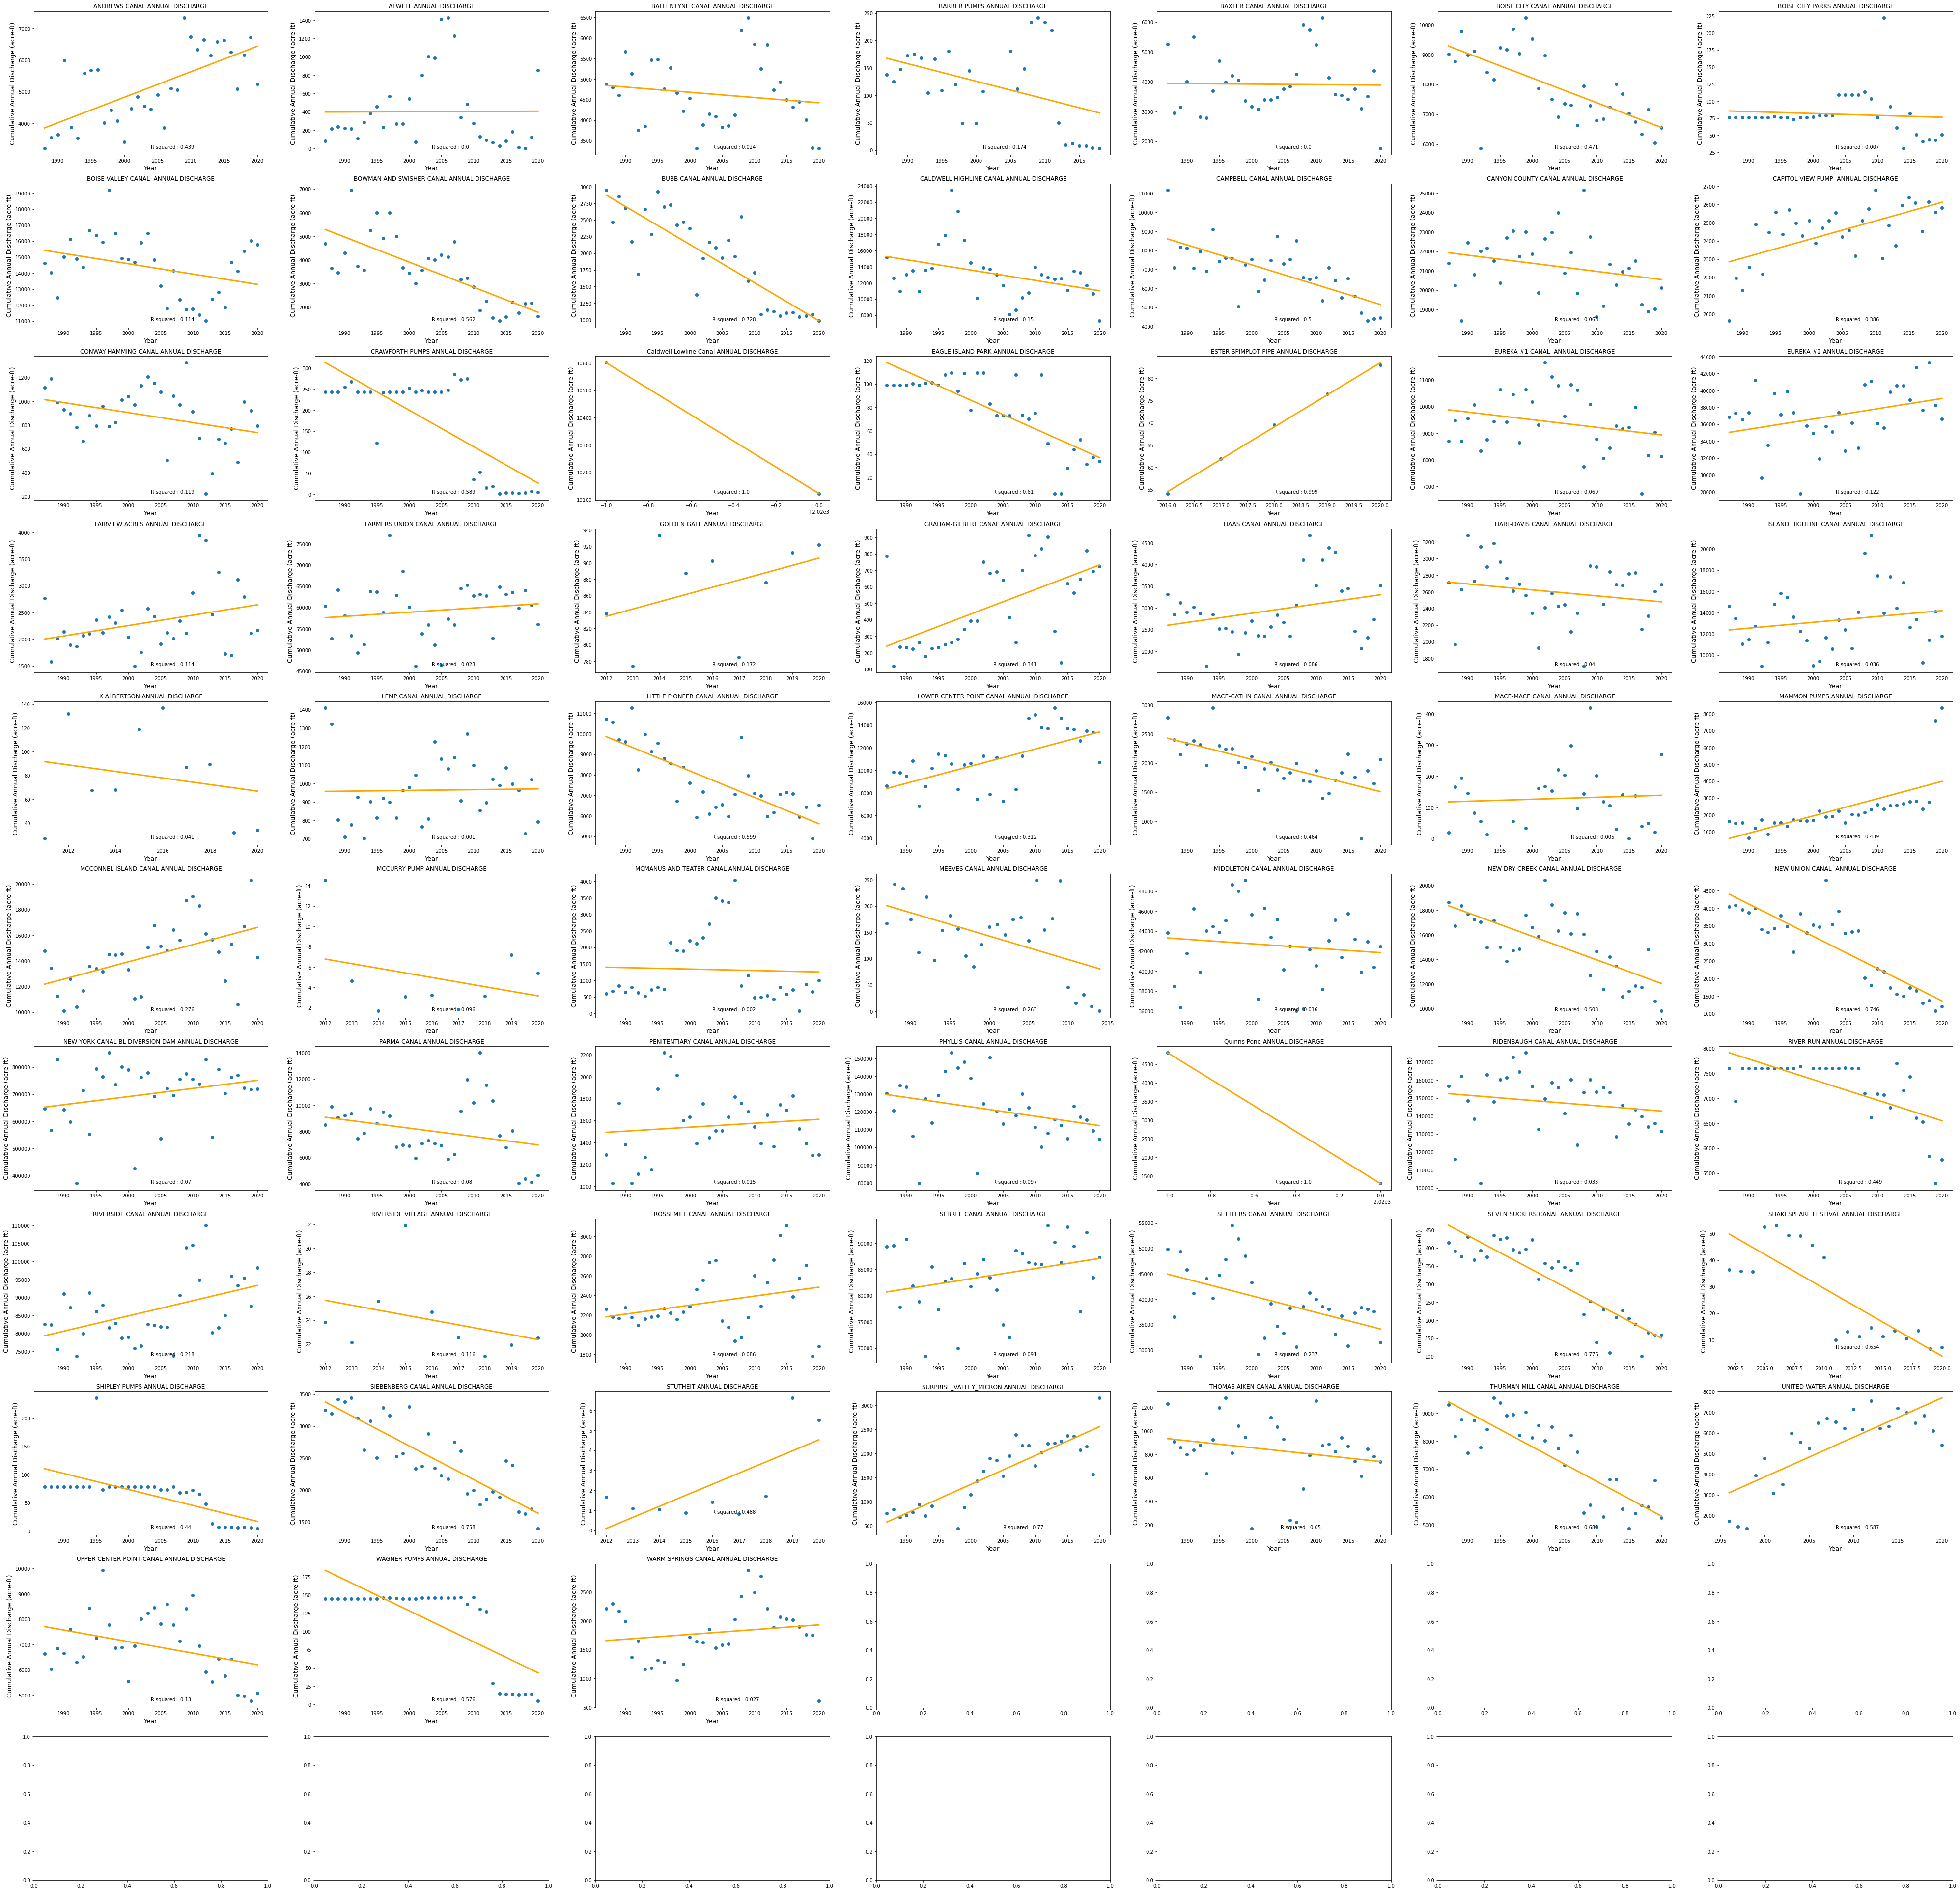

In [ ]:
### FIND THE TOTAL WATER DIVERTED ANNUALLY ###


tot = full_df.groupby([full_df['Year'],'Name']).sum(['Acre_feet'])   \
      .sort_values('Name').reset_index().rename(columns={'level_0':'Year'}).sort_values(['Name','Year'])  \
      .reset_index() #use group by to sum the daily values and drop extra columns
tot = tot.replace(0, np.nan).dropna().reset_index().drop(columns=['level_0','index'],axis=1) #clip each drain to the correct extent
names = tot['Name'].unique()

## CALCULATE A REGRESSION FOR EACH DRAIN ## 

regress = []
rsquared = np.empty(len(names))

for i in range(len(names)):
  df = pd.DataFrame(tot[tot['Name']==names[i]])
  mod = np.polyfit(df['Year'].values, df['Acre_feet'].values, deg=1) #calculates model coefficients
  df['Model'] = np.polyval(mod, df['Year'].values) #calculate model output values
  rsquared[i] = metrics.r2_score(df['Acre_feet'].values, df['Model'].values) #calculate rsquared for model
  regress.append(df)

regression= pd.concat(regress) #put list of dataframes into one

## CREATE SUBPLOTS FOR THE CHART ##

i,j = 0,0
plot_row = 7 #number of plots per row in figure
figure, ax = plt.subplots(11, plot_row, figsize=(70,70)) #create the figure

for n in range(len(names)): #run a for loop to add all plots to figure
  canal = regression[regression['Name']==names[n]]
  ax[i][j].plot(canal['Year'], canal['Acre_feet'], 'o')
  ax[i][j].plot(canal['Year'], canal['Model'], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Cumulative Annual Discharge (acre-ft)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' ANNUAL DISCHARGE')
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(np.median(canal['Year']), np.min(canal['Acre_feet']), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/totals.png')

In [ ]:
## CALCULATE BASIC VOLUME STATISTICS ##

stats = []

for i in range(len(canals)):
  canal = canals[i]
  totals = tot[tot['Name'] == canal['Name'][0]]
  avg_annual = np.mean(totals['Acre_feet'])
  std_annual = np.std(totals['Acre_feet'])
  avg_vol = np.mean(canal['Acre_feet'][canal['Acre_feet'] != 0])
  std_dev_vol = np.std(canal['Acre_feet'][canal['Acre_feet'] != 0])
  maximum = np.max(totals['Acre_feet'])
  minimum = np.min(totals['Acre_feet'])
  stats.append([canal['Name'][0], avg_annual, std_annual, maximum, minimum, avg_vol,
                std_dev_vol])

base_stats = pd.DataFrame(stats, columns = ['DiversionName', 'Annual Avg (acre-ft/yr)', 'Annual Std (acre-ft/yr)',
                                            'Maximum', 'Minimum',
                                            'Mean Volume (acre-ft per day)', 
                                            'Std_dev Volume (acre-ft per day)' 
                                            ]).sort_values(by=['DiversionName']).reset_index().drop(columns='index',axis=1)

base_stats.to_csv('datasets/diversion_timeseries/figures/stats.csv')

In [ ]:
## FIND IRRIGATION SEASON TIMING METRICS ##

## Create a dataframe housing info:                 ##
## ------------------------------------------------ ##
## Column 1: Name of diversion                      ##
## Column 2: Date start of Irrigation season        ##
## Column 3: Day of year start of Irrigation season ##
## Column 4: Date end of irrigation season          ##
## Column 5: Date of year end of Irrigation season  ##
## Column 6: Length of Irrigation Season            ##
## ------------------------------------------------ ##

season_df = []
years = np.arange(1987,2021)

## Add a column to original canals dataframe to get the daily cumulative sum of 
#  discharge each year during the irrigation season (used for start and end days)
for i in range(len(canals)):
  for j in range(len(years)):
    sub_canal = canals[i]
    canals[i]['Sum'] = sub_canal.groupby(sub_canal.index.year)['Diversion (cfs)'].cumsum()

for i in range(len(canals)):
  length = []
  for y in range(len(years)):
    canal_data = canals[i]
    canal_name = canal_data['Name'][1]
    canal_by_year = canal_data[canal_data.index.year == years[y]]
    if np.max(canal_by_year['Sum']) != 0:
      min_Ix = np.where(canal_by_year['Sum'] == np.min(canal_by_year['Sum']))
      min_Ix = min_Ix[0]
      min_Ix = min_Ix[-1]
      start_date = canal_by_year.index[min_Ix]
      start_dayofyear = canal_by_year.index.dayofyear[min_Ix]
    else:
      start_date = 'NaN'
      start_dayofyear = 'NaN'
    if np.max(canal_by_year['Sum'] != 0):
      max_Ix = np.where(canal_by_year['Sum'] == np.max(canal_by_year['Sum']))
      max_Ix= max_Ix[0]
      max_Ix = max_Ix[0]
      end_date = canal_by_year.index[max_Ix]
      end_dayofyear = canal_by_year.index.dayofyear[max_Ix]
    else: 
      end_date = 'NaN'
      end_dayofyear ='NaN'
    if end_date != 'NaN':
      irrig_season_range = end_dayofyear-start_dayofyear
    else: 
      irrig_season_range == 'NaN'
    length.append([canal_name, years[y], start_date, start_dayofyear, end_date, end_dayofyear, irrig_season_range])
  length_df = pd.DataFrame(length, columns = ['DiversionName','Year', 'StartDate', 'StartDayofYear',
                                            'EndDate', 'EndDayofYear', 'Range']).dropna()
  length_df = length_df.reset_index().drop('index', axis=1)
  season_df.append(length_df)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})


In [ ]:
## ------------------------------------------------------------------- ##
## GET EARLIEST AND LATEST DATES FOR START AND END OF SEASON EACH YEAR ## 
## ------------------------------------------------------------------- ##

timing = pd.concat(season_df)
timing['MonthStart'] = pd.DatetimeIndex(timing['StartDate']).month
timing['MonthEnd'] = pd.DatetimeIndex(timing['EndDate']).month
## Analyze where the irrigation starts and ends at anamolous times
jan = timing[timing['MonthStart'] == 1]
print(jan['DiversionName'].unique())
feb = timing[timing['MonthStart'] == 2]
# print(feb['DiversionName'].unique())
dec = timing[timing['MonthEnd'] == 12]
# print(dec['DiversionName'].unique())

## Remove diversions with anamolous start and end dates
min_test = timing[timing['DiversionName'] != 'NEW YORK CANAL BL DIVERSION DAM']
min_test = min_test[min_test['DiversionName'] != 'SURPRISE_VALLEY_MICRON']
min_test = min_test[min_test['DiversionName'] != 'UNITED WATER']
min_test = min_test[(min_test['DiversionName'] != 'RIVER RUN') | (min_test['Year'] != 2015)]
min_test = min_test[(min_test['DiversionName'] != 'RIVER RUN') | (min_test['Year'] != 2016)]
min_test = min_test[(min_test['DiversionName'] != 'RIVER RUN') | (min_test['Year'] != 2017)]
min_test = min_test[(min_test['DiversionName'] != 'SEVEN SUCKERS CANAL') | (min_test['Year'] != 1998)]
min_test = min_test[(min_test['DiversionName'] != 'SEVEN SUCKERS CANAL') | (min_test['Year'] != 1997)]
min_vals = pd.DataFrame(min_test.groupby('Year').StartDate.agg('min'))
max_vals = pd.DataFrame(min_test.groupby('Year').EndDate.agg('max'))

## Get the earliest start and latest end date of the irrigation season 
min_max = min_vals.merge(max_vals, on='Year', how='left')
min_max = min_max.rename({'min':'Start Date',
                          'mean_x':'Mean Start',
                          'max': 'End Date',
                          'mean_y':'Mean End'}, axis=1)

min_max.to_csv('datasets/climate_stats/start_end_dates.csv')

['NEW YORK CANAL BL DIVERSION DAM' 'RIVER RUN' 'SEVEN SUCKERS CANAL'
 'SURPRISE_VALLEY_MICRON' 'UNITED WATER']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})


In [ ]:
## Set anomalous start and end dates to the start and end of the irrigation season based on min and max dates ##

dates = []
for i in start_end['Year']:
  sub = timing[timing['Year'] == i].dropna()
  start = int(start_end['StartDOY'][start_end['Year']==i])
  end = int(start_end['EndDOY'][start_end['Year']==i])
  sub['StartDayofYear'].values[sub['StartDayofYear'] < start] = start
  sub['EndDayofYear'].values[sub['EndDayofYear'] > end] = end
  sub['StartDate'].values[sub['StartDayofYear']< start] = start_end['StartDate'][start_end['Year']==i] 
  sub['EndDate'].values[sub['EndDayofYear'] > end] = start_end['EndDate'][start_end['Year']==i]
  sub['Range'] = sub['EndDayofYear'] - sub['StartDayofYear'] 
  dates.append(sub)

new_timing = pd.concat(dates)

In [ ]:
## --------------------------------------- ##
## EXPORT ANNUAL STATS (VOLUME AND TIMING) ##
## --------------------------------------- ##

merge_files = []

for i in names:
  time = new_timing[new_timing['DiversionName'] == i]
  vol = tot[tot['Name'] == i].reset_index().drop('index', axis=1)
  merge = vol.merge(time, on='Year', how='right').dropna().reset_index().drop(['index','DiversionName'], axis=1)
  out_path = os.path.join('datasets/diversion_timeseries/final_stats/'+i+'.csv')
  merge.to_csv(out_path)
  merge_files.append(merge)

In [ ]:
## --------------------------------------------- ##
## OUPUT A FULLY MERGED DATAFRAME FOR MODEL IN R ##
## --------------------------------------------- ##

full_data = pd.concat(merge_files).sort_values(by='Name').reset_index().drop('index', axis=1)
out_path = 'datasets/diversion_timeseries/final_stats/model_inputs.csv' #EDIT for new ouput location
full_data.to_csv(out_path)


In [ ]:
## BASIC STATISTICS ON TIMING ##

time_stats = []

for i in range(len(canals)):
  canal_timing = season_df[i]
  avg_start = np.mean(canal_timing['StartDayofYear'][canal_timing['StartDayofYear'] != 'NaN'])
  std_start = np.std(canal_timing['StartDayofYear'][canal_timing['StartDayofYear'] != 'NaN'])
  avg_end = np.mean(canal_timing['EndDayofYear'][canal_timing['EndDayofYear'] != 'NaN'])
  std_end = np.std(canal_timing['EndDayofYear'][canal_timing['EndDayofYear'] != 'NaN'])
  avg_length = np.mean(canal_timing['Range'][canal_timing['Range'] != 'NaN'])
  std_length = np.std(canal_timing['Range'][canal_timing['Range'] != 'NaN'])
  time_stats.append([canal_timing['DiversionName'][1], avg_start, std_start, avg_end, std_end, avg_length, 
                     std_length])
  
time_stats = pd.DataFrame(time_stats, columns = ['DivName', 'avg_start', 'std_start', 
                                                 'avg_end','std_end', 'avg_length', 
                                                 'std_length'])

time_stats.to_csv('datasets/diversion_timeseries/figures/time_stats.csv')

In [ ]:
## Test if time series is stationary ##
## Mann_Kendall Test : A nonparametric test often used to detect changes in streamflow

# Test if volume time series is stationary
outs = []

for i in range(len(canals)):
  canal = canals[i]
  input = np.array(canal['CFS'])
  test = mk.seasonal_test(input, period=365, alpha=0.05)
  trend, hyp, pval, slope = [test.trend, test.h, test.p, test.slope]
  outs.append([canal['DiversionName'][0], trend, hyp, pval, slope])

mannkend_out = pd.DataFrame(outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope'])
# display(mannkend_out)

# Test to see if annual time series is stationary 

annual_outs = []

for i in range(len(canals)):
  canal = canals[i]
  annual = totals[:,i]
  test = mk.original_test(annual, alpha = 0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  annual_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])
  
mannkend_annual = pd.DataFrame(annual_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
display(mannkend_annual)
mannkend_annual.to_csv('datasets/diversion_timeseries/figures/mannkend_annual.csv')

# Test if length of irrigation season time series is stationary

length_outs = []

for i in range(len(canals)):
  canal = season_df[i]
  input = np.array(canal['Range'][canal['Range'] != 'NaN'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  length_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])

mannkend_length = pd.DataFrame(length_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
# display(mannkend_length)

# Test if centroid time series is stationary

centroid_outs = []

for i in range(len(canals)):
  canal = centroid_df[i]
  input = np.array(canal['CentroidDay'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope = [test.trend, test.h, test.p, test.slope]
  centroid_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope])

mannkend_centroid = pd.DataFrame(centroid_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope'])
# display(mannkend_centroid)




,Name,Trend,Hypothesis,Pvalue,Slope,Intercept
0,BALLENTYNE CANAL,no trend,False,1.634693e-01,-20.395963,4907.056282
1,BARBER PUMPS,decreasing,True,8.936597e-03,-4.170087,179.385194
2,BOISE CITY CANAL,decreasing,True,1.715019e-05,-85.555695,9191.197578
3,BOISE CITY PARKS,no trend,False,8.096686e-01,0.000000,76.165464
4,BOISE VALLEY CANAL (INCLUDED IN FARMERS UNION),no trend,False,6.602838e-02,-55.122313,15590.897330
5,BUREAU OF RECLAMATION INSTREAM FLOW RELEASE,increasing,True,1.981651e-04,957.873273,23323.412221
6,BUBB CANAL,decreasing,True,1.768054e-08,-60.860710,3023.974951
7,CALDWELL HIGHLINE CANAL,decreasing,True,2.423927e-02,-98.475892,14662.475534
8,CAMPBELL CANAL,decreasing,True,9.976408e-06,-94.932195,8635.984225
9,CANYON COUNTY CANAL,no trend,False,1.462806e-01,-44.718780,22107.300669


In [ ]:
## Add trend from Mann Kendall Test to volume stats and timing stats dataframes

base_stats['AnnualTrend'] = mannkend_annual['Trend']
time_stats['CentTrend'] = mannkend_centroid['Trend']
time_stats['LengthTrend'] = mannkend_length['Trend']

In [ ]:
## Calculate the annual percent change based on Mann Kendall slope and intercept

percent_change = []
for i in range(len(canals)):
  canal = canals[i]
  mann_row = mannkend_annual[mannkend_annual['Name'] == canal['DiversionName'][0]]
  if mann_row['Hypothesis'][i] == False:
    percent_change.append('Nan')
  elif str(mann_row['Trend'][i]) == 'increasing':
    end_val = mann_row['Intercept'][i]+mann_row['Slope'][i]*34
    change = (end_val-mann_row['Intercept'][i])/mann_row['Intercept'][i]
    percent_change.append(change)
  else:
    end_val = mann_row['Intercept'][i]+mann_row['Slope'][i]*34
    change = (mann_row['Intercept'][i]-end_val)/mann_row['Intercept'][i]
    percent_change.append(change)

base_stats['Intercept'] = mannkend_annual['Intercept']
base_stats['Slope(acre-ft)'] = mannkend_annual['Slope']
base_stats['PercentChange'] = percent_change

#Export an easy to read summary of each diversion
base_stats.to_csv('datasets/diversion_timeseries/figures/changethroughtime.csv')

In [ ]:
## Group canals based on the amount of discharge ##
## --------------------------------------------- ## 

mean50inc = []
mean50dec = []
mean10inc = []
mean10dec = []
mean0inc = []
mean0dec = []

for i in range(len(canals)):
  canal = base_stats.loc[i]
  if canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'increasing':
    mean50inc.append(canal)
  elif canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'decreasing':
    mean50dec.append(canal)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'increasing':
    mean10inc.append(canal)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'decreasing':
    mean10dec.append(canal)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'increasing':
    mean0inc.append(canal)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'decreasing':
    mean0dec.append(canal)
  else: 
    None


2
3
0
6
2
11


['BUBB CANAL']
['GRAHAM-GILBERT CANAL']
['LEMP CANAL']
['MACE-MACE CANAL']
['PENITENTIARY CANAL']
['SURPRISE_VALLEY_MICRON']
5
8
12


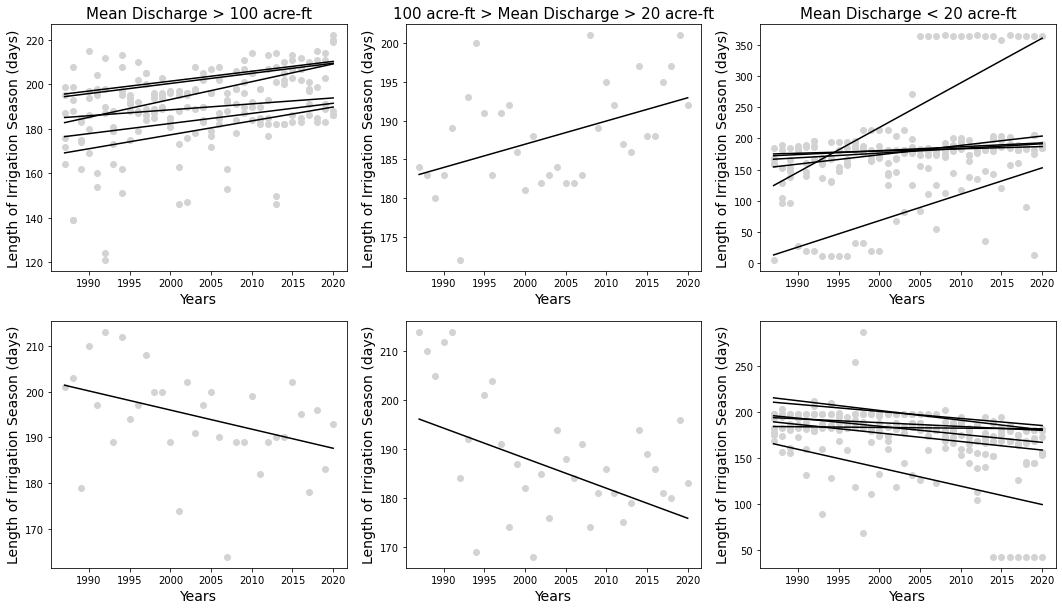

In [ ]:
## ---------------------------- ##
## CREATING FIGURES FOR RESULTS ## 
## ---------------------------- ##

figure, ax = plt.subplots(2, 3, figsize = (18,10))
year_slope = np.arange(0,34,1)
text = 'No increasing diversions'

for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  length = season_df[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'increasing':
    ax[0][0].plot(years, length['Range'], 'o', color='lightgrey')
    ax[0][0].set_xlabel('Years', size = 14)
    ax[0][0].set_ylabel('Length of Irrigation Season (days)', size=14)
    ax[0][0].set_title('Mean Discharge > 100 acre-ft', size=15)
  elif vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'decreasing':
    ax[1][0].plot(years, length['Range'], 'o', color='lightgrey')
    ax[1][0].set_xlabel('Years', size = 14)
    ax[1][0].set_ylabel('Length of Irrigation Season (days)', size=14)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'increasing':
    ax[0][1].plot(years, length['Range'], 'o', color='lightgrey')
    ax[0][1].set_xlabel('Years', size = 14)
    ax[0][1].set_ylabel('Length of Irrigation Season (days)', size=14)
    ax[0][1].set_title('100 acre-ft > Mean Discharge > 20 acre-ft', size = 15)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'decreasing':
    ax[1][1].plot(years, length['Range'], 'o', color='lightgrey')
    ax[1][1].set_xlabel('Years', size = 14)
    ax[1][1].set_ylabel('Length of Irrigation Season (days)', size=14)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'increasing':
    ax[0][2].plot(years, length['Range'], 'o', color='lightgrey')
    ax[0][2].set_xlabel('Years', size = 14)
    ax[0][2].set_ylabel('Length of Irrigation Season (days)', size=14)
    ax[0][2].set_title('Mean Discharge < 20 acre-ft', size=15)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'decreasing':
    ax[1][2].plot(years, length['Range'], 'o', color='lightgrey')
    ax[1][2].set_xlabel('Years', size = 14)
    ax[1][2].set_ylabel('Length of Irrigation Season (days)', size=14)
  else: 
    None

for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'increasing':
    ax[0][0].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'decreasing':
    ax[1][0].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'increasing':
    ax[0][1].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'decreasing':
    ax[1][1].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'increasing':
    print([canal['Name']])
    ax[0][2].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'decreasing':
    ax[1][2].plot(years, (canal['Intercept']+canal['Slope']*year_slope), color='black')
  else: 
    None

plt.savefig('datasets/diversion_timeseries/figures/results_length.svg')

notrend50 = []
notrend10 = []
notrend0 = []
for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'no trend':
    notrend50.append(canal)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'no trend':
    notrend10.append(canal)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'no trend':
    notrend0.append(canal)
  else: 
    None

print(len(notrend50))
print(len(notrend10))
print(len(notrend0))


In [ ]:
mean50inc = []
mean50dec = []
mean10inc = []
mean10dec = []
mean0inc = []
mean0dec = []

for i in range(len(canals)):
  canal = base_stats.loc[i]
  length = mannkend_length.loc[i]
  if canal['Mean Discharge(cfs)'] > 50 and length['Trend'] == 'increasing':
    mean50inc.append(canal)
  elif canal['Mean Discharge(cfs)'] > 50 and length['Trend'] == 'decreasing':
    mean50dec.append(canal)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and length['Trend'] == 'increasing':
    mean10inc.append(canal)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and length['Trend'] == 'decreasing':
    mean10dec.append(canal)
  elif canal['Mean Discharge(cfs)'] < 10 and length['Trend'] == 'increasing':
    mean0inc.append(canal)
  elif canal['Mean Discharge(cfs)'] < 10 and length['Trend'] == 'decreasing':
    mean0dec.append(canal)
  else: 
    None

print(len(mean50inc))
print(len(mean50dec))
print(len(mean10inc))
print(len(mean10dec))
print(len(mean0inc))
print(len(mean0dec))

6
1
1
1
6
7


5
8
12


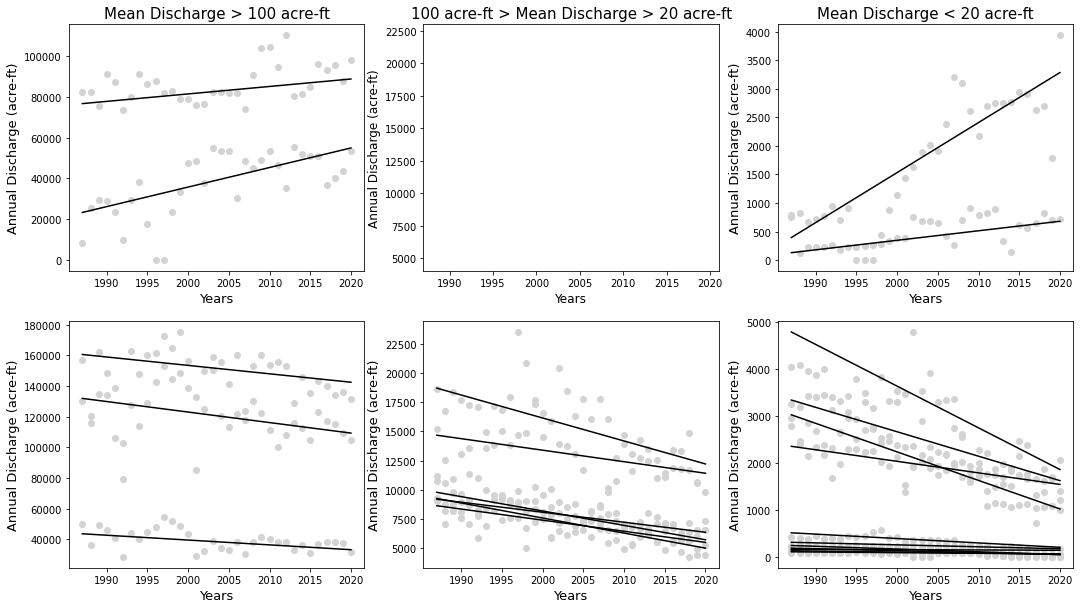

In [ ]:
## ---------------------------- ##
## CREATING FIGURES FOR RESULTS ## 
## ---------------------------- ##

## Change in Annual Volume Trends: 
figure, ax = plt.subplots(2, 3, figsize = (18,10))
year_slope = np.arange(0,34,1)
text = 'No increasing diversions'

for i in range(len(canals)):
  canal = base_stats.loc[i]
  ann_tots = totals[:,i]
  if canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'increasing':
    ax[0][0].plot(years, ann_tots, 'o', color='lightgrey')
    ax[0][0].set_xlabel('Years', size = 13)
    ax[0][0].set_ylabel('Annual Discharge (acre-ft)', size=13)
    ax[0][0].set_title('Mean Discharge > 100 acre-ft', size=15)
  elif canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'decreasing':
    ax[1][0].plot(years, ann_tots, 'o', color='lightgrey')
    ax[1][0].set_xlabel('Years', size = 13)
    ax[1][0].set_ylabel('Annual Discharge (acre-ft)', size=13)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][1].plot(years, ann_tots, 'o', color='lightgrey')
    ax[0][1].set_xlabel('Years', size = 13)
    ax[0][1].set_ylabel('Annual Discharge (acre-ft)', size=13)
    ax[0][1].set_title('100 acre-ft > Mean Discharge > 20 acre-ft')
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][1].plot(years, ann_tots, 'o', color='lightgrey')
    ax[1][1].set_xlabel('Years', size = 13)
    ax[1][1].set_ylabel('Annual Discharge (acre-ft)', size=13)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][2].plot(years, ann_tots, 'o', color='lightgrey')
    ax[0][2].set_xlabel('Years', size = 13)
    ax[0][2].set_ylabel('Annual Discharge (acre-ft)', size=13)
    ax[0][2].set_title('Mean Discharge < 20 acre-ft', size=15)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][2].plot(years, ann_tots, 'o', color='lightgrey')
    ax[1][2].set_xlabel('Years', size = 13)
    ax[1][2].set_ylabel('Annual Discharge (acre-ft)', size=13)
  else: 
    ax[0][1].set_title('100 acre-ft > Mean Discharge > 20 acre-ft', size=15)
    ax[0][1].set_xlim([1987, 2021])
    ax[0][1].set_ylim([4000, 23000])
    ax[0][1].set_xlabel('Years', size=12)
    ax[0][1].set_ylabel('Annual Discharge (acre-ft)', size=12)
    # ax[0][1].text(1995, 17500, text)

for i in range(len(canals)):
  canal = base_stats.loc[i]
  if canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'increasing':
    ax[0][0].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope),color='black')
  elif canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'decreasing':
    ax[1][0].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope), color='black')
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][1].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope))
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][1].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope), color='black')
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][2].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope), color='black')
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][2].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope), color='black')
  else: 
    None
plt.savefig('datasets/diversion_timeseries/figures/results_discharge.svg')

notrend50 = []
notrend10 = []
notrend0 = []
for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'no trend':
    notrend50.append(canal)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'no trend':
    notrend10.append(canal)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'no trend':
    notrend0.append(canal)
  else: 
    None

print(len(notrend50))
print(len(notrend10))
print(len(notrend0))
